Code for determining how to adjust VonMises dispersion parameter in cursor probabilistic model based on proximity to target.

We'll use a logistic function (as seen below) with parametrized midpoint and steepness.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0, 0.5, 'Kappa multiplier')

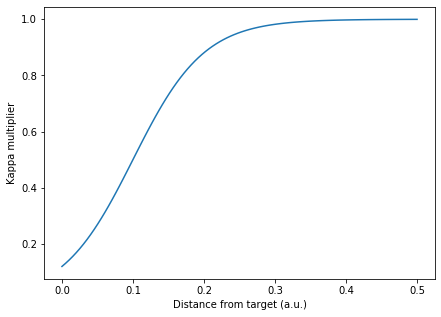

In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np


import sys
sys.path.append('../utils/plotting/')
sys.path.append('../utils/recalibration/')
sys.path.append('../utils/simulation/')
from plotting_utils import figSize
from hmm import hmmviterbi_vonmises, hmmdecode_vonmises
from simulation import simulateBCIFitts
from simulation_utils import * 

# for a reproducible result
np.random.seed(1)

# plot our template kappa adjustment function
def adjustFunc(dists):
    weight = 1./(1 + np.exp(-1 * (dists-0.1)*20))
    return weight


figSize(5, 7)
plt.plot(np.linspace(0, 0.5, 100), adjustFunc(np.linspace(0, 0.5, 100)))
plt.xlabel('Distance from target (a.u.)')
plt.ylabel('Kappa multiplier')

#### Define an initial decoder and initial neural tuning properties (mean firing rates and preferred directions).


In [4]:
'''The first column of initialTuning is the means, and the second two columns are the preferred directions. 
We make sure that the last two columns are orthogonal (uniformly distributed PDs) 
and that the tuning strength is set to 1 (norm of the column is 1). '''

nUnits        = 192
SNR           = 0.5

initialTuning = generateUnits(n_units = nUnits, SNR = SNR)

In [5]:
'''Generate initial decoder '''
from sklearn.linear_model import LinearRegression

nTrainingSteps = 10000
calVelocity    = np.random.normal(size = (nTrainingSteps, 2))
calNeural      = calVelocity.dot(initialTuning[:,1:].T)  + initialTuning[:, 0].T;  # FR = <velocity, PD> + baseline
calNeural      = calNeural + np.random.normal(size = calNeural.shape) * 0.3      # add gaussian noise

lr             = LinearRegression(fit_intercept = True).fit(calNeural, calVelocity)
D              = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_]).T

# Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(initialTuning[:, 1])
D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(initialTuning[:, 2])


In [6]:
'''Here we define the amount of exponential smoothing used in the decoder (alpha). Values between 0.9 and 0.96 are pretty reasonable. See the paper
'A comparison of intention estimation methods for decoder calibration in intracortical brain-computer interfaces' for an explanation of how velocity Kalman 
filters can be parameterized with a smoothing parameter (alpha), gain parameter (beta, see next section below) and decoding matrix (D). '''

alpha       = 0.94
delT        = 0.01 # define the time step (10 ms)
nDelaySteps = 20   # define the simulated user's visual feedback delay (200 ms)

### Do a quick sweep of cursor gains to find the optimal one for this task.

This is really important so that any new recalibration algorithm doesn't improve performance simply by coincidence,
via randomly changing the gain to some better value.

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
Using gain value beta =  1.3888888888888888


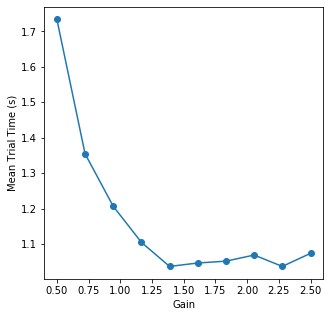

In [7]:
'''
The task we are simulating is a fitts style task where targets randomly
appear within a box centered at the origin. To acquire the target, the
user must hold the cursor on top of the target for half a second. The
performance metric of interest is the average total trial time (TTT), or
the average amount of time it takes to reach to and fully hold on a target. 

The 'simulateBCIFitts' does all the work of simulating the BCI user, the
neural activity, and the decoder. It returns time series data you can use
to see the cursor trajectory and target locations (posTraj & velTraj are
the cursor positions and velocities, rawDecTraj is the raw decoded
velocity vectors before they are smoothed, conTraj is the user's internal
control vector, targTraj is a time series of target locations, neuralTraj
is a time series of neural activity, trialStart contains the time step on
which each trial started, and ttt has the trial time (in seconds) for each
trial. '''
import matplotlib.pyplot as plt 
figSize(5,5)

possibleGain = np.linspace(0.5,2.5,10)
nSimSteps    = 50000
meanTTT      = np.zeros((len(possibleGain),))

for g in range(len(possibleGain)):
    print(str(g) + ' / ' + str(len(possibleGain)))
    posTraj, velTraj, rawDecTraj, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts(initialTuning, D,alpha, possibleGain[g], nDelaySteps, delT, nSimSteps)
    meanTTT[g] = np.mean(ttt)

plt.figure()
plt.plot(possibleGain, meanTTT, '-o')
plt.xlabel('Gain')
plt.ylabel('Mean Trial Time (s)')

minIdx = np.argmin(meanTTT)
beta   = possibleGain[minIdx]

print('Using gain value beta = ', beta)


In [28]:
# general settings:
nSimSteps  = 10000

# HMM settings:
vmKappa    = 2          # Precision parameter for the von mises distribution
probThresh = 0.4
gridSize   = 20
stayProb   = 0.9999

# grid search settings:
inflection_sweep = np.linspace(0, 0.5, 21)
exp_sweep        = np.linspace(1, 40, 11)

#inflection_sweep = [0.0, 0.05, 0.1]
#exp_sweep        = [20, 30, 40]

#--------------------------------------------------
sweep_scores = np.zeros((len(inflection_sweep), len(exp_sweep))) 

nStates                 = gridSize**2
targLocs                = generateTargetGrid(gridSize = gridSize)
stateTrans, pStateStart = generateTransitionMatrix(gridSize = gridSize, stayProb = stayProb)


ttt       = simulateBCIFitts(initialTuning, D, alpha, beta, nDelaySteps, delT, nSimSteps)[-1] # Simulate BCI performance with matched neural tuning and decoder, and an optimized gain
print('Performance with original decoder: ' , np.mean(ttt))

newTuning                                              = simulateTuningShift(initialTuning, PD_shrinkage = 0.3)                          # now introduce nonstationarities
cursorPos, _, decOut, _, targTraj, neural, _, ttt_new  = simulateBCIFitts(newTuning, D, alpha, beta, nDelaySteps, delT, nSimSteps)   # simulate performnance with old decoder
print('Performance with nonstationarity: ', np.mean(ttt_new))


for i, inflection in enumerate(inflection_sweep):
    for j, exp in enumerate(exp_sweep):
        
        def adjustKappa(dist):
            coef = 1 / (1 + np.exp(-1 * (dist - inflection) * exp))
            return coef 
        
        targStates, logP = hmmviterbi_vonmises(decOut, stateTrans, targLocs, cursorPos, pStateStart, vmKappa, adjustKappa = adjustKappa)
        pTargState, pSeq = hmmdecode_vonmises(decOut,  stateTrans, targLocs, cursorPos, pStateStart, vmKappa, adjustKappa = adjustKappa)
        inferredPosErr   = targLocs[targStates.astype('int').flatten() - 1,:] - cursorPos

        D_new          = np.linalg.lstsq(np.hstack([np.ones((neural.shape[0], 1)), neural]), inferredPosErr, rcond = -1)[0]
        decVec_new     = np.hstack([np.ones((neural.shape[0], 1)), neural]).dot(D_new)

        #Important: normalize the decoder so that D_new decoders vectors of magnitude 1 when far from the target. 
        #This will restore the original optimal gain.
        inferredTargDist = np.linalg.norm(inferredPosErr, axis = 1)
        inferredTargDir  = inferredPosErr / inferredTargDist[:, np.newaxis]
        farIdx           = np.where(inferredTargDist > 0.4)[0]
        projVec          = np.sum(np.multiply(decVec_new[farIdx, :], inferredTargDir[farIdx, :]), axis = 1)
        D_new           /= np.mean(projVec)

        
        ttt_recal          = simulateBCIFitts(newTuning, D_new, alpha, beta, nDelaySteps, delT, nSimSteps)[-1] #Simulate BCI performance with the HMM-recalibrated decoder
        sweep_scores[i, j] = np.mean(ttt_recal)
        
    print(np.round((i + 1) * 100 / len(inflection_sweep), 2), '% complete.')
    

Performance with original decoder:  1.0158163265306122
Performance with nonstationarity:  2.0582978723404253
4.76 % complete.
9.52 % complete.
14.29 % complete.
19.05 % complete.
23.81 % complete.
28.57 % complete.
33.33 % complete.
38.1 % complete.
42.86 % complete.
47.62 % complete.
52.38 % complete.
57.14 % complete.
61.9 % complete.
66.67 % complete.
71.43 % complete.
76.19 % complete.
80.95 % complete.
85.71 % complete.
90.48 % complete.
95.24 % complete.
100.0 % complete.


Best inflection:  0.15000000000000002
Best exponent:  4.9


Text(0.5, 1.0, 'Average time-to-target for different kappa adjustment parameters')

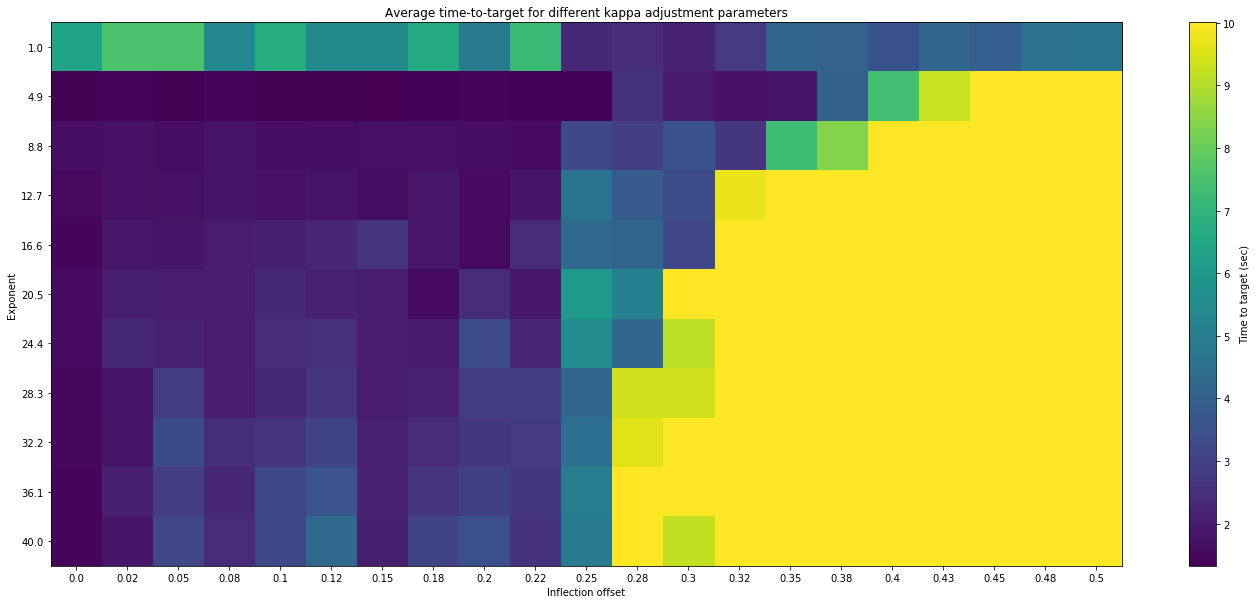

In [32]:
figSize(10, 24)

argx, argy = np.unravel_index(np.argmin(sweep_scores), sweep_scores.shape)
print('Best inflection: ', inflection_sweep[argx])
print('Best exponent: ', exp_sweep[argy])

plt.imshow(sweep_scores.T, aspect = 'auto')
plt.xticks(np.arange(len(inflection_sweep)), np.round(inflection_sweep, 2))
plt.yticks(np.arange(len(exp_sweep)), np.round(exp_sweep, 2))
plt.colorbar(label = 'Time to target (sec)')
#plt.clim([0, 2])
plt.xlabel('Inflection offset')
plt.ylabel('Exponent')
plt.title('Average time-to-target for different kappa adjustment parameters', fontsize = 12)